In [1]:
%pip install tensorflow matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np

# Configuration
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

print("TensorFlow Version:", tf.__version__)

2025-11-29 12:31:32.933691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764419492.955494    9122 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764419492.962079    9122 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764419492.978777    9122 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764419492.978801    9122 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764419492.978803    9122 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0


In [2]:
# Download official Malaria dataset
dataset_url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
print("Downloading dataset... (this may take 1-2 minutes)")

data_path = tf.keras.utils.get_file(
    origin=dataset_url, 
    fname="cell_images.zip", 
    extract=True
)

# Set the path to the extracted folder
data_dir = pathlib.Path(data_path).parent / "cell_images"
print(f"✅ Data ready at: {data_dir}")

✅ Data ready at: /home/azureuser/.keras/datasets/cell_images


In [4]:
import os
import pathlib

# This is where we THINK the data is
suspected_path = pathlib.Path("/home/azureuser/.keras/datasets")

print(f"🕵️ Looking inside: {suspected_path}\n")

found = False
# Walk through the folders to find the 'Parasitized' folder
for root, dirs, files in os.walk(suspected_path):
    if "Parasitized" in dirs:
        print(f"✅ FOUND IT! The real path is:")
        print(f"{root}")
        found = True
        break

if not found:
    print("❌ Could not find the images. The download might be corrupt.")
    print("Try deleting the hidden .keras folder and downloading again.")

🕵️ Looking inside: /home/azureuser/.keras/datasets

✅ FOUND IT! The real path is:
/home/azureuser/.keras/datasets/cell_images_extracted/cell_images


In [5]:
import tensorflow as tf
import pathlib

# --- THE FIX: Update path to the one found by your script ---
data_dir = pathlib.Path("/home/azureuser/.keras/datasets/cell_images_extracted/cell_images")
print(f"Using path: {data_dir}")

# Parameters (ensure these match your config)
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

print("Creating Training Set...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("Creating Validation Set...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("\nClasses found:", class_names)

# Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Using path: /home/azureuser/.keras/datasets/cell_images_extracted/cell_images
Creating Training Set...
Found 27558 files belonging to 2 classes.
Using 22047 files for training.


2025-11-29 12:37:28.488019: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Creating Validation Set...
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.

Classes found: ['Parasitized', 'Uninfected']


In [6]:
# 1. Load the pre-trained ResNet50 (without the top layer)
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # Freeze it for Phase 1

# 2. Add our custom classifier on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs) # Essential for ResNet
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

# 3. Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
print("Starting Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)
print("Training Finished!")

Starting Training...
Epoch 1/5


2025-11-29 12:38:49.135313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 453 of 1000
2025-11-29 12:38:59.271915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


689/689 ━━━━━━━━━━━━━━━━━━━━ 1380s 2s/step - accuracy: 0.7417 - loss: 0.5140 - val_accuracy: 0.8866 - val_loss: 0.2934
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 1373s 2s/step - accuracy: 0.8596 - loss: 0.3206 - val_accuracy: 0.9035 - val_loss: 0.2462
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 1451s 2s/step - accuracy: 0.8854 - loss: 0.2741 - val_accuracy: 0.9096 - val_loss: 0.2263
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 1323s 2s/step - accuracy: 0.9014 - loss: 0.2503 - val_accuracy: 0.9167 - val_loss: 0.2134
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 1311s 2s/step - accuracy: 0.9070 - loss: 0.2379 - val_accuracy: 0.9261 - val_loss: 0.2032
Training Finished!


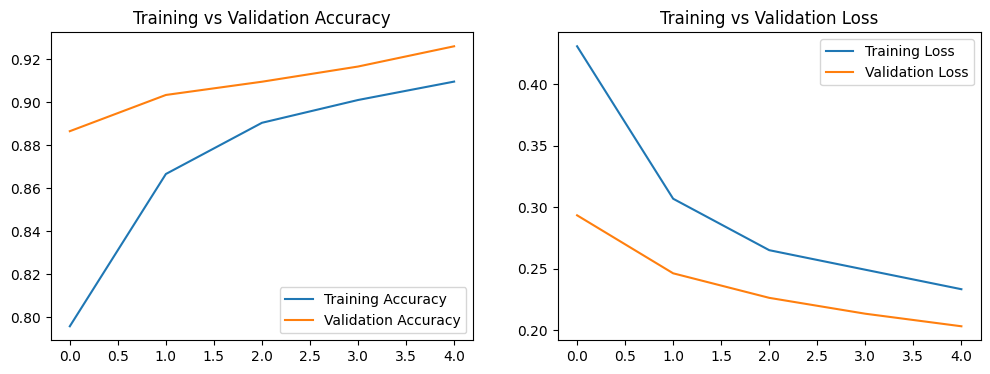

In [8]:
# Save the entire model to a file
model.save('malaria_model.keras')
print("✅ Model saved as 'malaria_model.keras'")

In [9]:
# Save the entire model to a file
model.save('malaria_model.keras')
print("✅ Model saved as 'malaria_model.keras'")

✅ Model saved as 'malaria_model.keras'
